# Toxic_Language
## Machine Learning Course Project
---
### Author: Naoya Kumakura
### Date: June 2025
---
## Data: 
Dataset is derived from comments written by Wikipedia contributors. Alongside a
majority of regular (“ok”) messages, you can find a variety of negative comments. A
sample of these has been collected and manually classified as:
- ‘ok’;
- ‘hate’;
- ‘insult’;
- ‘obscene’;
- ‘toxic’;
- ‘threat’.

28,000 training comments, divided in 
4,000 test comments

The data are stored in text files, with one headline for each line.


## Goal:
Build classifiers for the detection of the 6 types of class label. We need to onsider two scenarios: accuracy oriented and fpr oriented.

---

```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import string
import re
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import collections

---

### 1 - **DATA ANALYSIS**



Notations:

- The test.csv and train.csv 

/home/naoya/pv2/machinelearning/lastassignment/Offensive_Message_Classification
Train label distribution:
Counter({'ok': 13780, 'insult': 5693, 'toxic': 4983, 'obscene': 1973, 'hate': 1153, 'threat': 418})
Test label distribution:
Counter({'ok': 1995, 'insult': 807, 'toxic': 724, 'obscene': 260, 'hate': 154, 'threat': 60})


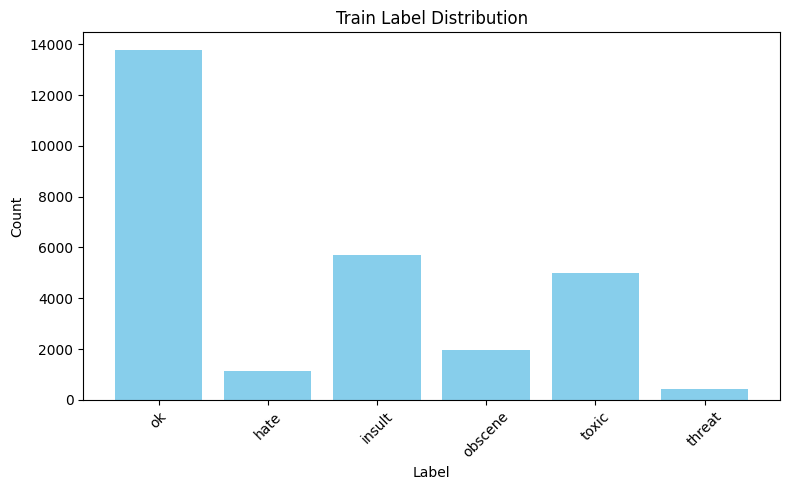

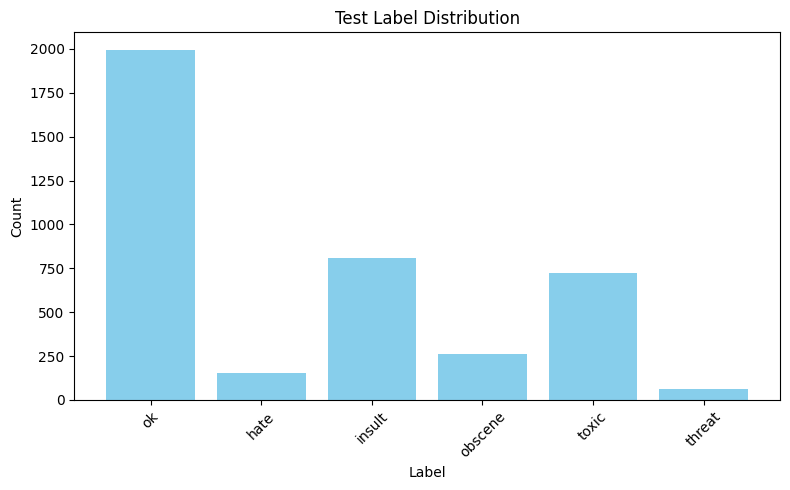

In [2]:
def read_labels_from_csv(filepath):
    labels = []
    with open(filepath, encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            labels.append(row['label'].strip())
    return np.array(labels)

def plot_label_distribution(labels, title, filename):
    label_counts = Counter(labels)
    # 表示順を固定
    order = ['ok', 'hate', 'insult', 'obscene', 'toxic', 'threat']
    counts = [label_counts.get(label, 0) for label in order]

    plt.figure(figsize=(8, 5))
    plt.bar(order, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def main():
    train_labels = read_labels_from_csv("toxic-language-csv/train.csv")
    test_labels = read_labels_from_csv("toxic-language-csv/test.csv")

    print("Train label distribution:")
    print(Counter(train_labels))

    print("Test label distribution:")
    print(Counter(test_labels))

    plot_label_distribution(train_labels, "Train Label Distribution", "train_label_distribution.png")
    plot_label_distribution(test_labels, "Test Label Distribution", "test_label_distribution.png")

if __name__ == "__main__":
    !pwd
    main()


---

### 2 - **Preprocessing**


creating the BoW representation.

Create Vocabulary:
- **Tokenization**: the headlines are split into tokens, removing the punctuation and the stopwords.

Create the BoW representation:
- **CountVectorizer**: the headlines are represented as a matrix, where each row is a headline and each column is a token. The value of each cell is the number of times the token appears in the headline.

#### 2.1 Loading Data 

In [3]:
path = 'toxic-language-csv'
print("Path to dataset files:", path)
train_df = pd.read_csv('toxic-language-csv/train.csv')
test_df = pd.read_csv('toxic-language-csv/test.csv')

Xtrain, Ytrain = train_df['text'].tolist(), train_df['label'].tolist()
Xtest, Ytest = test_df['text'].tolist(), test_df['label'].tolist()

print(Xtrain[0])
print(Ytrain[0])

Path to dataset files: toxic-language-csv
Don't piss mme off! 'I MEEN IT YOU DLEATED BOLTH OF MY ARTICLES THE AMERICAN DAD VS FAMILY GUY AND THE BUBBLE STRUGGLE 2 ARTICLE I'M GOING TO SEW YOU FOR $10000000000000000000000000000000000000000000 I WISH I COULD YOU SON OF A ***** ******* *******!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ( )
insult


#### Converting Labels(Ytrain/test) into ID

In [4]:
labels = ['ok','hate','insult', 'obscene', 'toxic', 'threat'] 
label2id = {label: idx for idx, label in enumerate(labels)}

Ytrain_id = [label2id[label] for label in Ytrain]
Ytest_id = [label2id[label] for label in Ytest]
print(Ytrain_id[0])

2


#### 2.2 Count the number of each words
- Split with `tokenize(text)`
- Using Counter class,  we count all of the words
- `most_common` shows the highest number of words

In [ ]:
def tokenize(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return text.split()

# 出現頻度カウント
all_words = []
for text in Xtrain:
    all_words.extend(tokenize(text))
word_counts = Counter(all_words)

# 上位10単語を図示
most_common = word_counts.most_common(10)
vocab = {word: idx for idx, (word, _) in enumerate(most_common)}

print(most_common)

[('the', 65186), ('you', 48598), ('to', 42503), ('a', 37928), ('i', 35596), ('and', 34887), ('of', 31113), ('is', 28022), ('that', 21531), ('in', 19758)]


#### 2.3 Make Dictionary into BoW vector


In [ ]:
def make_bow(text, vocabulary):
    bow = torch.zeros(len(vocabulary), dtype=torch.float)
    for word in tokenize(text):
        if word in vocabulary:
            bow[vocabulary[word]] += 1
    return bow

class BoWDataset(Dataset):
    def __init__(self, bows, labels):
        self.bows = bows
        self.labels = labels

    def __len__(self):
        return len(self.bows)

    def __getitem__(self, idx):
        return self.bows[idx], self.labels[idx]


bows = [make_bow(text, vocab) for text in Xtrain]
train_dataset = BoWDataset(bows, Ytrain_id)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### 3 Learning with Naive Bayes

In [ ]:
def train_nb(X, Y):
    """Train a binary NB classifier."""
    # 事前確率の計算
    prior_prob = torch.mean(Y.float())
    print ("P(y)",prior_prob)
    b = torch.log(prior_prob/(1-prior_prob))
    print ("b",b)

IndexError: list index out of range

In [ ]:
alpha = 1.0
class_word_counts += alpha
class_totals = class_word_counts.sum(dim=1, keepdim=True)
log_probs = torch.log(class_word_counts / class_totals)  # log P(word|class)
log_class_priors = torch.log(class_counts / class_counts.sum())  # log P(class)

print("log_probs shape:", log_probs.shape)
print("log_class_priors shape:", log_class_priors.shape)